In [1]:
import pkufiber as pf
import yaml 
import torch 
from scripts.train_eq import init_model, check_data_config, DataLoader, test_model

path = '/home/xiaoxinyu/pkufiber/experiments/80G_3ch_pbc_v1'
with open(path + '/config.yaml') as f: config = yaml.load(f, Loader=yaml.FullLoader)
param_dict = torch.load(path + '/models/1.pth', map_location='cpu')['model_param']
model = init_model(config['model_name'], config['model_info'])
model.load_state_dict(param_dict) 
test_path =  "/home/xiaoxinyu/TorchFiber/dataset_A800/test.h5" 

In [3]:
Q = []
for pch in range(-3, 8):
    data = pf.data.PbcDataset(path=test_path, Nmodes=2, Nch=3, Rs=80, Pch=pch, 
                    window_size=801,  num_symb=100000, truncate=20000)

    dataloader = DataLoader(data, batch_size=20000, shuffle=False)

    Q.append(test_model(model, dataloader, device='cpu')['Qsq'])

In [17]:
import numpy as np
np.save('result/pbc.npy', Q) 

In [2]:
id_model = pf.dsp.nonlinear_compensation.nneq.EqID(M=41)
test_model(id_model, dataloader, device='cpu')

{'MSE': 0.02908763475716114,
 'SNR': 15.35193654699853,
 'BER': 0.0033076002262532713,
 'Qsq': 8.677376664408975}

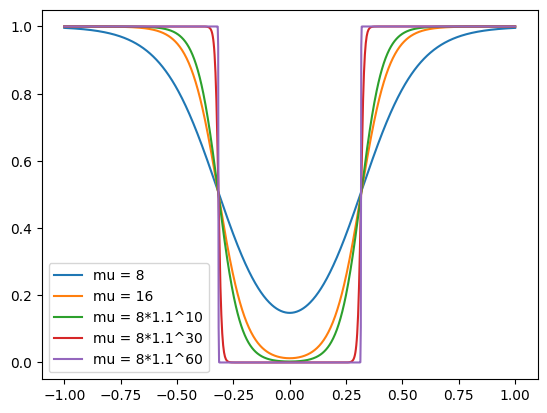

In [25]:
import pkufiber as pf
import pkufiber.dsp.nonlinear_compensation.loss as loss 
import torch 
import matplotlib.pyplot as plt

x = torch.linspace(-1,1,1000)


y_ber = loss.well(x, mu=8*1.1**100)

y1 = loss.well(x, mu=8)
y2 = loss.well(x, mu=16)
y3 = loss.well(x, mu=8*1.1**10)
y4 = loss.well(x, mu=8*1.1**30)
y5 = loss.well(x, mu=8*1.1**60)


# plt.plot(x, y_ber, label='BER')
plt.plot(x, y1, label='mu = 8')
plt.plot(x, y2, label='mu = 16')
plt.plot(x, y3, label='mu = 8*1.1^10')
plt.plot(x, y4, label='mu = 8*1.1^30')
plt.plot(x, y5, label='mu = 8*1.1^60')
plt.legend()

In [33]:
import pkufiber as pf
from pkufiber.dsp.nonlinear_compensation.pbc import  EqAMPBC, EqAMPBCstep
import torch 

x = torch.randn(5, 100, 2, dtype=torch.complex64)
task = torch.randn(5, 4)
model = EqAMPBCstep(M=41, rho=8, fwm_share=True, decision=False)

In [35]:
torch.sum(torch.abs(model(x, task) - x[:,20:-20,:]))

tensor(5.7704e-06, grad_fn=<SumBackward0>)

In [25]:
import pkufiber as pf 
import pkufiber.dsp.nonlinear_compensation as nl 
import torch



batch = 2000
M = 41
rho = 1
# device = 'cuda:0'
device = 'cuda:0'

net = nl.EqAMPBCstep(M=M, rho=rho)
net = net.to(device)
x = torch.rand(batch, M + 41, 2) + 1j
x = x.to(device)
task = torch.rand(batch, 4) 
task = task.to(device)


%timeit net(x, task)    

14.5 ms ± 1.53 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
import pkufiber as pf 
import pkufiber.dsp.nonlinear_compensation as nl 
import torch



batch = 2000 
M = 41
overlaps = 40
rho = 1
strides = 10
# device = 'cuda:0'
device = 'cuda:0'

net = nl.EqFrePBC(M=M, rho=rho, overlaps=overlaps)
net = net.to(device)
x = torch.rand(batch, strides + overlaps, 2) + 1j
x = x.to(device)
task = torch.rand(batch, 4) 
task = task.to(device)
%timeit net(x, task)    

61.7 ms ± 34.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


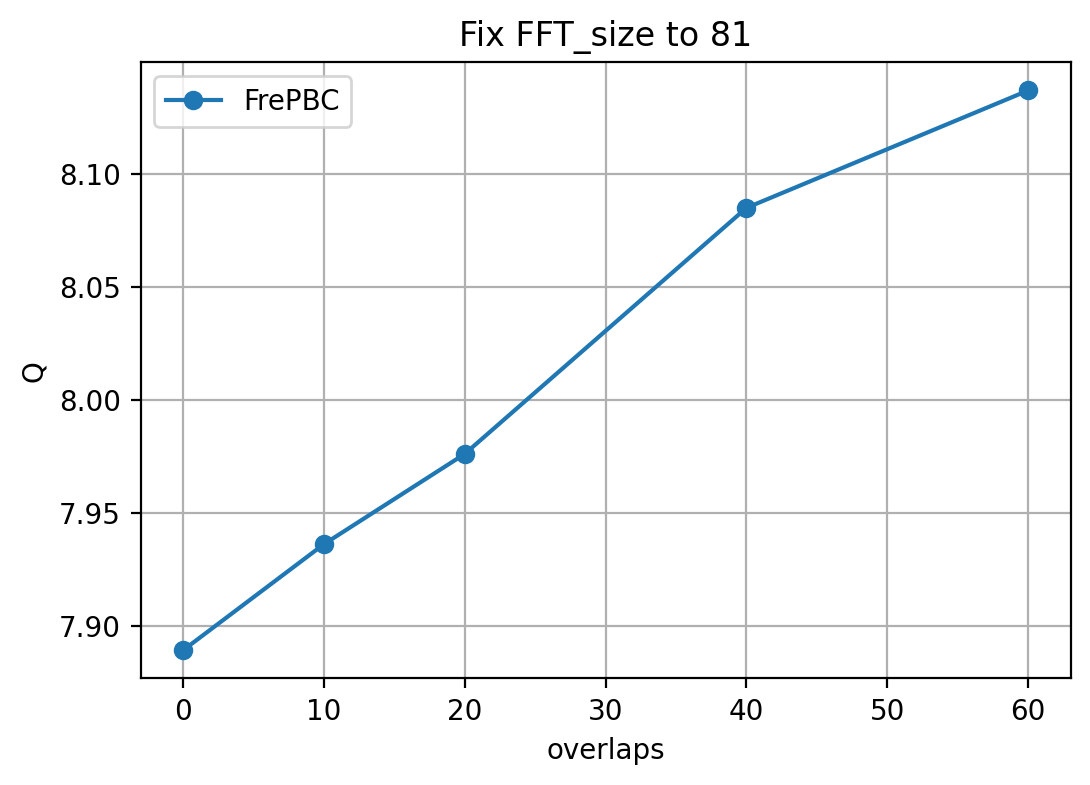

In [16]:
ol = [0, 10, 20, 40, 60]
Q = [7.889, 7.936, 7.976, 8.085, 8.137]


plt.figure(figsize=(6,4), dpi=200)
plt.plot(ol, Q, '-o', label='FrePBC')
plt.xlabel('overlaps')
plt.ylabel('Q')
plt.title('Fix FFT_size to 81')
plt.legend()
plt.grid()

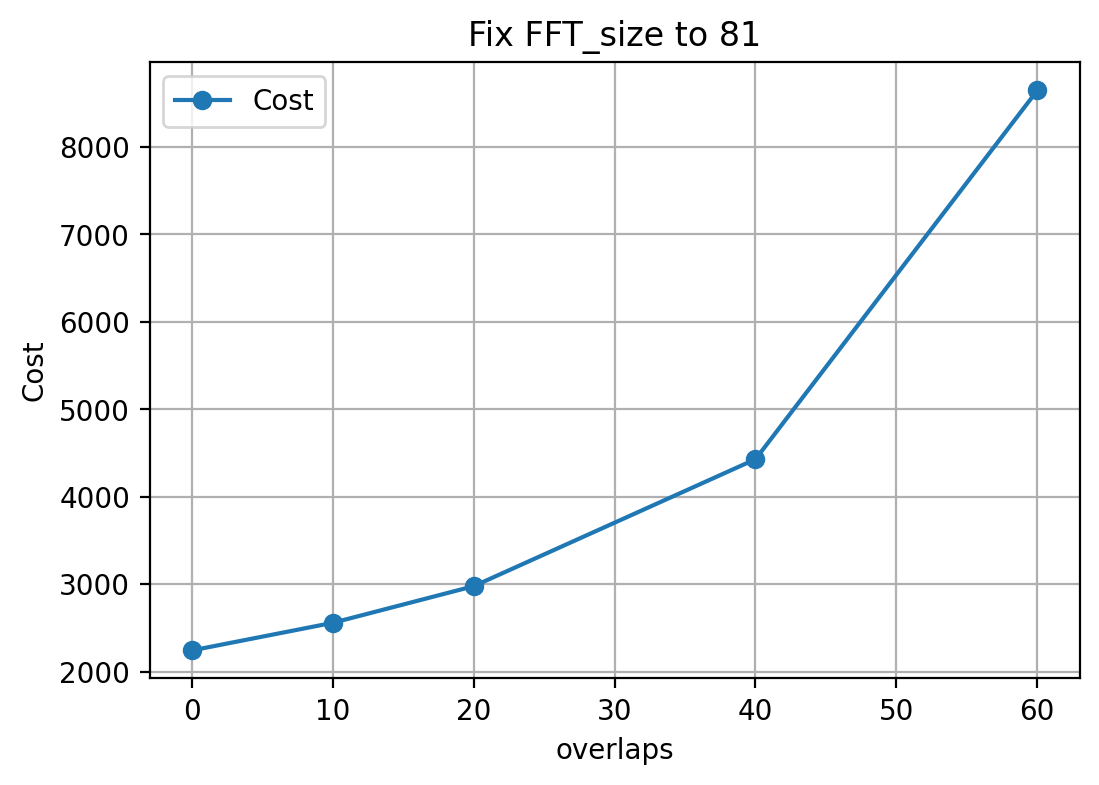

In [19]:
import numpy as np

def  hb(M, rho):
    return 6*rho*M*np.log(rho*M/2)

def fft(FFT_size):
    return FFT_size * np.log2(FFT_size)

def Cost(FFT_size, overlaps, M, rho):
    return (hb(M, rho)*FFT_size*3 + 2*fft(FFT_size))/(FFT_size - overlaps)


FFT_size = 81
M = 41
rho = 1
overlaps = [0, 10, 20, 40, 60]
cost = [Cost(FFT_size, ol, M, rho) for ol in overlaps]

plt.figure(figsize=(6,4), dpi=200)
plt.plot(overlaps, cost, '-o', label='Cost')
plt.xlabel('overlaps')
plt.ylabel('Cost')
plt.title('Fix FFT_size to 81')
plt.legend()
plt.grid()


In [32]:
import matplotlib.pyplot as plt


rho1 = [0.1, 0.2, 0.4, 0.8, 1, 2]
Cost1 = [hb(41, rho) for rho in rho1]
Q1 = [7.965, 8.034, 8.069, 8.08, 8.089, 8.09]

rho2 = [0.1, 0.2, 0.5, 1, 2, 4, 8, 16]
Cost2 = [Cost(81,40,41, rho) for rho in rho2]
Q2 =  [7.703, 7.724, 7.79, 7.878, 7.951, 8.007, 8.023, 8.023]

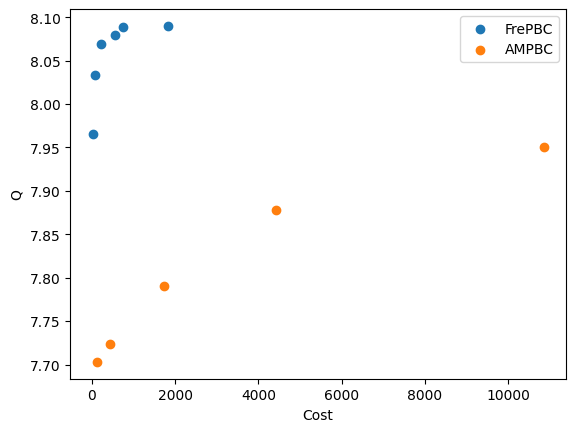

In [34]:
plt.scatter(Cost1, Q1, label='FrePBC')
plt.scatter(Cost2[0:5], Q2[0:5], label='AMPBC')

plt.xlabel('Cost')
plt.ylabel('Q')
plt.legend()

In [ ]:
plt.figure(figsize=(6,4), dpi=200)
plt.plot(rho1, Q1, '-o', label='FrePBC')
plt.plot(rho2, Q2,  '-o', label='AMPBC')
plt.xlabel('rho')
plt.ylabel('Q')
plt.legend()
plt.grid()
#plt.savefig('result/rho.png')

$$
\frac{fftsize}{fftsize - overlaps} \left(6\rho L\log(\frac{\rho L}{2}) + 2 \log_2(fftsize)\right)
$$

$$
6\rho L\log(\frac{\rho L}{2})
$$

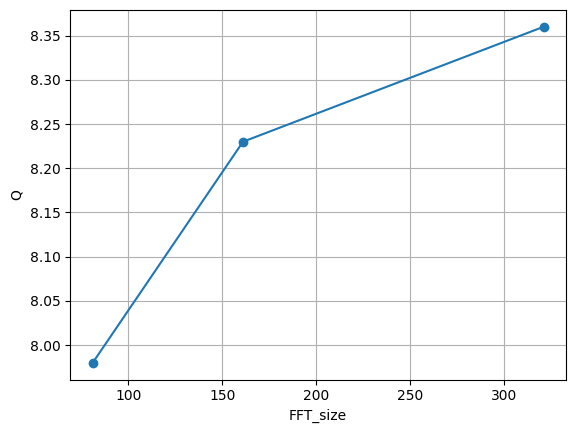

In [38]:
FFT_size = [81, 161, 321]
Q = [7.98, 8.23, 8.36]

plt.plot(FFT_size, Q, '-o')
plt.xlabel('FFT_size')
plt.ylabel('Q')
plt.grid()

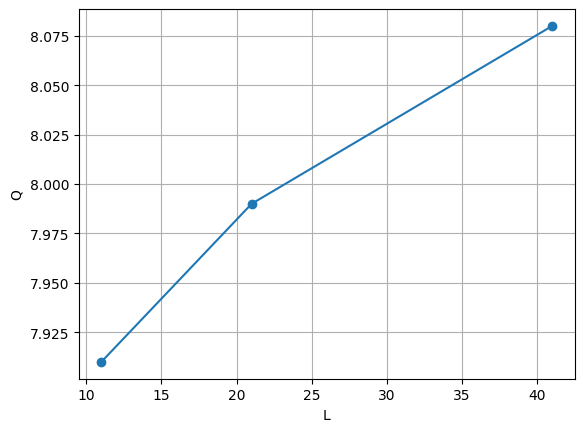

In [39]:
FFT_size = [11, 21, 41]
Q = [7.91, 7.99, 8.08]

plt.plot(FFT_size, Q, '-o')
plt.xlabel('L')
plt.ylabel('Q')
plt.grid()

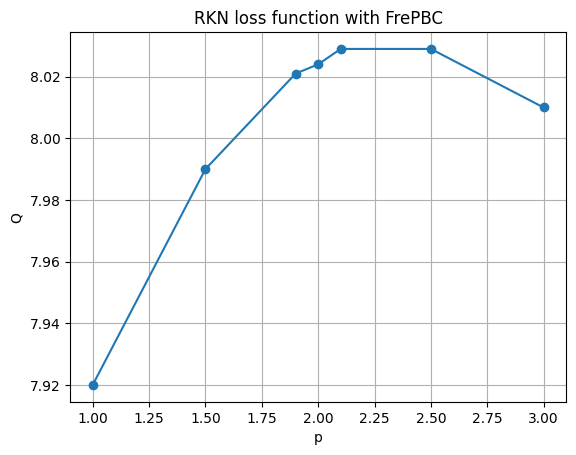

In [3]:
import matplotlib.pyplot as plt
p = [1, 1.5, 1.9, 2, 2.1, 2.5, 3]
Q = [7.92, 7.99, 8.021, 8.024, 8.029, 8.029, 8.01]

plt.plot(p, Q, '-o')
plt.xlabel('p')
plt.ylabel('Q')
plt.title('RKN loss function with FrePBC')
plt.grid()
